## Описание проекта

Интернет-сервис запускает функционал общения с клиентами у себя на сайте. Необходимо построить модель детектирования негативных сообщений для дальнейшей обработки сервисной службой.

### Цели
- Обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности сообщений.
- Построить модель со значением метрики качества *F1* не меньше 0.75.


### Инструкция по выполнению проекта
1. Загрузить и подготовить данные.
2. Обучить разные модели.
3. Сделать выводы.


### Описание данных
Данные находятся в файле `toxic_comments.csv`.
- **text** - текст комментария,
- **toxic** - целевой признак.

In [27]:
# !pip install transformers
# !pip install accelerate -U
# !pip install -q -U watermark
# !pip install time
# !pip install torchsummary
# !pip re

In [28]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.7.0

numpy       : 1.23.5
pandas      : 1.5.2
torch       : 2.0.1+cu117
transformers: 4.25.1



In [29]:
try:
    import numpy as np
    import pandas as pd
    import torch
    import transformers
    import seaborn as sns
    import matplotlib.pyplot as plt


    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score,f1_score
    from transformers import BertTokenizer, BertModel,BertConfig
    import time
    import re

    from torch.utils.data import DataLoader, TensorDataset
    from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoModelForMaskedLM,AutoModel
    from torch.utils.data import DataLoader, Dataset
    from transformers import  BertForSequenceClassification, Trainer, TrainingArguments
    from torchsummary import summary

    print('библиотеки ок')
except:
    print('Грузим pip')

библиотеки ок


In [30]:
# посчитаем общее времечко, чтобы ревью прошло быстренько=)
start_time_all = time.time()
rn=1977
# размер семпла
sam=1500

## Загрузка датасета

In [31]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv',index_col=0)
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv',index_col=0)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


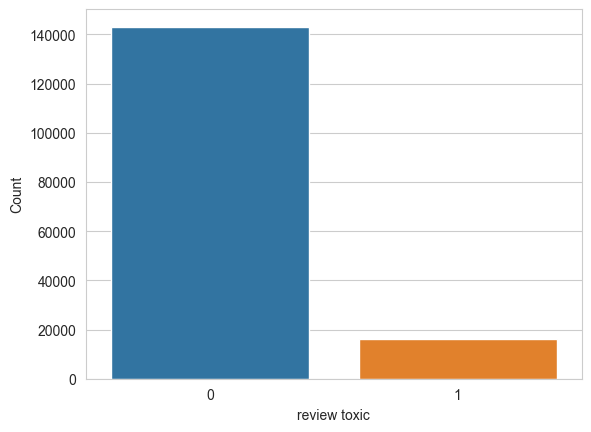

баланс классов [143106  16186]


In [33]:

# Подсчет количества значений
value_counts = data['toxic'].value_counts()

# Построение графика countplot
sns.countplot(x='toxic', data=data, order=value_counts.index)

plt.xlabel('review toxic')
plt.ylabel('Count')

plt.show()

class_counts = np.bincount(data['toxic'])
print('баланс классов',class_counts)

ВИдим большой дисбаланс классов

In [34]:
# Проверяю, доступна ли видеокарта
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU доступна')
    print('Устройство:', torch.cuda.get_device_name())

    # Выводим информацию о видеопамяти
    total_mem = torch.cuda.get_device_properties(device).total_memory
    reserved_mem = torch.cuda.memory_reserved(device)
    allocated_mem = torch.cuda.memory_allocated(device)
    free_mem = total_mem - reserved_mem

    print('Всего памяти: ', round(total_mem / 1024**3, 2), 'GB')
    print('Используется памяти: ', round(allocated_mem / 1024**3, 2), 'GB')
    print('Зарезервировано памяти: ', round(reserved_mem / 1024**3, 2), 'GB')
    print('Свободной памяти: ', round(free_mem / 1024**3, 2), 'GB')
else:
    device = torch.device('cpu')
    print('GPU не доступна, используется CPU')

cuda
GPU доступна
Устройство: NVIDIA GeForce RTX 3070
Всего памяти:  8.0 GB
Используется памяти:  1.28 GB
Зарезервировано памяти:  7.14 GB
Свободной памяти:  0.86 GB


## Trainer

In [35]:
#обрежем
data = data.sample(sam).reset_index(drop=True)
data

,text,toxic
0,"Sometime back, I just happened to log on to ww...",0
1,"""\n\nThe latest edit is much better, don't mak...",0
2,""" October 2007 (UTC)\n\nI would think you'd be...",0
3,Thanks for the tip on the currency translation...,0
4,I would argue that if content on the Con in co...,0
...,...,...
1495,Sounds perfect! I'm going to work on it now.,0
1496,"""\n\nFirst of all the albanian migration in th...",0
1497,Hamboards \n\nI have removed the speedy deleti...,0
1498,"If you are a scholar, it would seem that you w...",0


In [36]:
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# model =AutoModelForMaskedLM.from_pretrained('unitary/toxic-bert')
# tokenizer = AutoTokenizer.from_pretrained('unitary/toxic-bert')
# model = AutoModelForSequenceClassification.from_pretrained('unitary/toxic-bert',num_labels=2)
# model = BertForSequenceClassification.from_pretrained('unitary/toxic-bert')
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')



In [37]:
# pretrained_path = "DeepPavlov/rubert-base-cased"


# Загрузите модель и токенизатор
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')
# tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
# model = transformers.AutoModel.from_pretrained('bert-base-uncased')



# Создаем классификатор на основе модели BERT
class BertForSequenceClassification(transformers.BertPreTrainedModel):
    # Конструктор класса
    def __init__(self, config):
        # Вызов конструктора родительского класса и инициализация с конфигурацией BERT
        super().__init__(config)
        # Число классов задается из конфигурации BERT
        self.num_labels = config.num_labels

        self.bert = model  # используйте загруженную модель BERT
        # Создание слоя dropout с заданной в конфигурации вероятностью
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        # Создание классификатора как полносвязного слоя
        self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels)

     # Определение прямого прохода модели
    def forward(
        self,
        input_ids=None,            # Идентификаторы токенов входных данных
        attention_mask=None,       # Маска внимания для входных данных
        token_type_ids=None,       # Идентификаторы типов токенов для входных данных
        position_ids=None,         # Идентификаторы позиций для входных данных
        head_mask=None,            # Маска для скрытия некоторых голов внимания
        inputs_embeds=None,        # Предварительно встроенные представления входных данных
        labels=None,               # Метки для вычисления функции потерь
        output_attentions=None,    # Флаг, определяющий, следует ли возвращать внимание
        output_hidden_states=None, # Флаг, определяющий, следует ли возвращать скрытое состояние
        return_dict=None,          # Флаг, определяющий, следует ли возвращать данные в виде словаря
    ):
        # Если return_dict не предоставлен, используется значение из конфигурации
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        # Прямой проход через модель BERT
        outputs = self.bert(

            input_ids,                      # Идентификаторы токенов входных данных
            attention_mask=attention_mask,  # Маска внимания для входных данных
            token_type_ids=token_type_ids,  # Идентификаторы типов токенов для входных данных
            position_ids=position_ids,      # Идентификаторы позиций для входных данных
            head_mask=head_mask,            # Маска для скрытия некоторых голов внимания
            inputs_embeds=inputs_embeds,    # Предварительно встроенные представления входных данных
            output_attentions=output_attentions,        # Флаг, определяющий, следует ли возвращать внимание
            output_hidden_states=output_hidden_states,  # Флаг, определяющий, следует ли возвращать скрытое состояние
            return_dict=return_dict,        # Флаг, определяющий, следует ли возвращать данные в виде словаряattention_mask=attention_mask,

        )
        # Извлечение выхода пула из выходов BERT
        pooled_output = outputs[1]
        # Применение dropout к выходу пула
        pooled_output = self.dropout(pooled_output)
        # Пропускание выхода пула через классификатор
        logits = self.classifier(pooled_output)

         # Если предоставлены метки, вычисление потерь
        if labels is not None:
            # Если число меток равно 1, то задача регрессии
            if self.num_labels == 1:
                # задача регрессии
                loss_fct = torch.nn.MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                # Используем кросс-энтропию для вычисления потери в задаче классификации
                loss_fct = torch.nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

            # Если не нужно возвращать словарь, то возвращаем кортеж из потерь, логитов и других выходных данных
            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            # Иначе возвращаем выходные данные в виде объекта SequenceClassifierOutput
            return transformers.modeling_outputs.SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )
        # Если метки не предоставлены, то просто возвращаем логиты и другие выходные данные
        if not return_dict:
            output = (logits,) + outputs[2:]
            return output
        # Иначе возвращаем выходные данные в виде объекта SequenceClassifierOutput
        return transformers.modeling_outputs.SequenceClassifierOutput(
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Используйте классификатор
model = BertForSequenceClassification(model.config)

# Теперь вы можете использовать свой классификатор в процессе обучен

loading configuration file config.json from cache at C:\Users\admin/.cache\huggingface\hub\models--unitary--toxic-bert\snapshots\5cc53435803a6e6f1ac8e4b243910d3bf26803ff\config.json
Model config BertConfig {
  "_name_or_path": "unitary/toxic-bert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "toxic",
    "1": "severe_toxic",
    "2": "obscene",
    "3": "threat",
    "4": "insult",
    "5": "identity_hate"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "identity_hate": 5,
    "insult": 4,
    "obscene": 2,
    "severe_toxic": 1,
    "threat": 3,
    "toxic": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "posi

Это дает более детальный обзор модели, включая размеры входов и выходов для каждого слоя и количество параметров.

In [ ]:
model.config

In [38]:
# Параметры и слои
for name, param in model.named_parameters():
    print(name, param.size())

bert.embeddings.word_embeddings.weight torch.Size([30522, 768])
bert.embeddings.position_embeddings.weight torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight torch.Size([2, 768])
bert.embeddings.LayerNorm.weight torch.Size([768])
bert.embeddings.LayerNorm.bias torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.bias torch.Size([768])
bert.encoder

In [39]:
 # Определение класса CustomDataset, который наследуется от класса Dataset в PyTorch
class CustomDataset(Dataset):

    # Определение функции __init__, которая выполняется при создании объекта CustomDataset
    # Эта функция принимает два аргумента: encodings и labels
    def __init__(self, encodings, labels):
        # Сохранение данных кодирования и меток в переменных экземпляра класса
        self.encodings = encodings
        self.labels = labels

    # Определение функции __getitem__, которая выполняется при получении элемента датасета по индексу
    def __getitem__(self, idx):
        # Формирование элемента датасета, преобразовывая все значения в тензоры PyTorch
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Добавление метки для данного элемента
        item['labels'] = torch.tensor(self.labels[idx])
        # Возвращение сформированного элемента
        return item

    # Определение функции __len__, которая возвращает количество элементов в датасете
    def __len__(self):
        return len(self.labels)

In [40]:
# Разделение данных на обучающую, валидационную и тестовую выборки
train_data, remaining = train_test_split(data, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(remaining, test_size=0.5, random_state=42)


In [41]:
train_data.shape,valid_data.shape,test_data.shape

((1200, 2), (150, 2), (150, 2))

In [42]:
# ТОкинезация длинна 512 и все возвращаем в вектора pyTorch
train_encodings = tokenizer(train_data['text'].to_list(), truncation=True, padding='max_length', max_length=512, return_tensors='pt')
valid_encodings = tokenizer(valid_data['text'].to_list(), truncation=True, padding='max_length', max_length=512, return_tensors='pt')
test_encodings = tokenizer(test_data['text'].to_list(), truncation=True, padding='max_length', max_length=512, return_tensors='pt')




In [43]:
train_labels = train_data['toxic'].to_list()
valid_labels = valid_data['toxic'].to_list()
test_labels = test_data['toxic'].to_list()

In [44]:
# дата сеты для тренера
train_dataset = CustomDataset(train_encodings, train_labels)
valid_dataset = CustomDataset(valid_encodings, valid_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

In [45]:
#чуть переделел чтобы логи и график сходимости сделать
training_args = TrainingArguments(
    output_dir='./results',                  # директория для вывода результатов
    num_train_epochs=3,                      # общее количество эпох обучения
    per_device_train_batch_size=8,          # размер пакета данных на каждом устройстве во время обучения
    per_device_eval_batch_size=32,           # размер пакета данных на каждом устройстве во время оценки
    warmup_steps=500,                        # количество шагов разогрева для планировщика скорости обучения
    weight_decay=0.01,                       # сила убывания веса
    logging_dir='./logs',                    # директория для хранения журналов
    load_best_model_at_end=True,             # загрузка тренировочной модели для теста
    logging_steps=10,                        # журнал и сохранение весов каждые `logging_steps`
    evaluation_strategy='steps',             # оценка  регистрируется при каждом  `logging_steps`
    save_strategy='steps',                   # контрольные точки модели сохраняются  `logging_steps`
    save_steps=500,                          # контрольные точки модели сохраняются каждые `save_steps`
)


using `logging_steps` to initialize `eval_steps` to 10
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [46]:
# # Функция метрики
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'f1_score': f1_score(y_true=labels, y_pred=predictions, average='weighted')}

In [47]:
# тренер
trainer = Trainer(
    model=model,                         # инициированная модель  Transformers, которую требуется обучить
    args=training_args,                   # определенные выше аргументы обучения
    train_dataset=train_dataset,         # обучающий датасет
    eval_dataset=valid_dataset,          # датасет для оценки(валидации)
    compute_metrics=compute_metrics,    # функция обратного вызова, которая вычисляет интересующие нас метрики
)

In [48]:
%%time
# тренеруем модель
trainer.train()

C:\Users\admin\PycharmProjects\venv\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1200
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 450
  Number of trainable parameters = 109486854
C:\Temp\ipykernel_7132\817352437.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 150
  Batch size = 32
C:\Temp\ipykernel_7132\817352437.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 150
  Batch size = 32
C:\Temp\ipykernel_7132\817352437.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 150
  Batch size = 32
C:\Temp\ipykernel_7132\817352437.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

CPU times: total: 5min 7s
Wall time: 5min 7s


TrainOutput(global_step=450, training_loss=0.2428837798991137, metrics={'train_runtime': 307.4883, 'train_samples_per_second': 11.708, 'train_steps_per_second': 1.463, 'total_flos': 947233817395200.0, 'train_loss': 0.2428837798991137, 'epoch': 3.0})

In [49]:
# валидируем
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 150
  Batch size = 32
C:\Temp\ipykernel_7132\817352437.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.03336578980088234,
 'eval_f1_score': 0.9866666666666667,
 'eval_runtime': 2.4251,
 'eval_samples_per_second': 61.854,
 'eval_steps_per_second': 2.062,
 'epoch': 3.0}

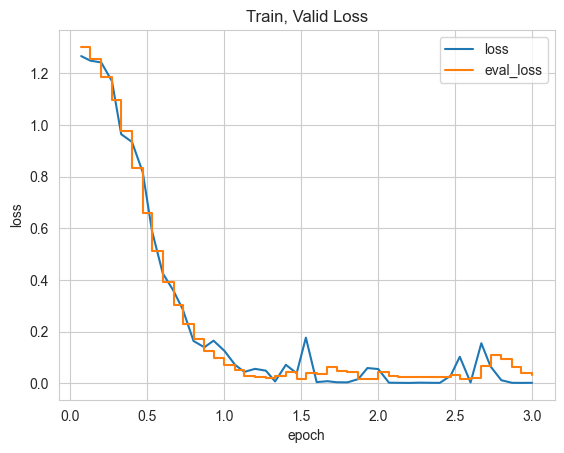

CPU times: total: 266 ms
Wall time: 273 ms


In [50]:
%%time
# Отображение графика сходимости
log_df = pd.DataFrame(trainer.state.log_history)
# Исключение строк с NaN значениями
# Замена NaN значениями ближайших соседей
df = pd.DataFrame()
df['loss'] = log_df['loss'].fillna(method='ffill').fillna(method='bfill')
df['eval_loss'] = log_df['eval_loss'].fillna(method='ffill').fillna(method='bfill')
# Построение графиков
plt.plot(log_df['epoch'], df['loss'], label='loss')
plt.plot(log_df['epoch'], df['eval_loss'], label='eval_loss')

# Настройки осей и легенды
plt.title('Train, Valid Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

# Отображение графика
plt.show()

### Тест

In [51]:
%%time
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 150
  Batch size = 32
C:\Temp\ipykernel_7132\817352437.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


CPU times: total: 2.14 s
Wall time: 2.14 s


{'eval_loss': 0.04960707202553749,
 'eval_f1_score': 0.9809237816516098,
 'eval_runtime': 2.139,
 'eval_samples_per_second': 70.126,
 'eval_steps_per_second': 2.338,
 'epoch': 3.0}

In [52]:
# общее время выполения кода(для комфорта проверки и заботы о ревьювере=)))....код завершен, общее время 6 мин
time_all=time.time()-start_time_all
print('код завершен, общее время',int(time_all/60),'мин')

код завершен, общее время 5 мин


# Вывод

о итогу выполнения проекта, были получены эмбеддинги от BERT, на основе которых были созданы модели обучения предсказания токсичности комментариев.( итог на большой выборке)





